<a href="https://colab.research.google.com/github/priyankaborwanker/Optiver-Trading-At-The-Close-Kaggle/blob/main/cse519_hw3_Borwanker_Priyanka_115599161.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### TOC
1. Anomalies in Data, and cleaning action & explaination. 15 pts
2. Pairwise Corralation Table and explaition. 10 pts
3. Average records stockID vs Day, 25 pts
    - a. autocorrelation, 10 pts
    - b. measure the distance, 5 pts
    - c. clustering algorithm, 10 pts
4. Closing trajectory of stocks on each day highly correlated, 25 pts
   - a. Make three plots, 10 pts
   - b. permutation test to determine the statistical confidence, 15 pts
      p-value
5. Best prediction model, any approaches, 25 pts
6. submit model on Kaggle, 0 pts

#### Start
- Copy this notebook.
  In Google Colab use `File -> Save a Copy in Drive`.
- Use the "Text" blocks to provide explanations wherever you find them necessary.
- Highlight your answers inside these text fields to ensure that we don't miss it
while grading your HW.

#### Setup

- Code to download the data directly from the colab notebook.
- If you find it easier to download the data from the kaggle website (and
uploading it to your drive), you can skip this section.

In [ ]:
## First mount your drive before running analysis code
from google.colab import drive
drive.mount('/content/drive')

## Create a folder for the this HW and change to that dir
%cd /content/drive/MyDrive/CSE519/HW3 - OPTIVER TRADING AT A CLOSE


Mounted at /content/drive
/content/drive/MyDrive/CSE519/HW3 - OPTIVER TRADING AT A CLOSE


In [ ]:
## packages
!pip install -q kaggle
!pip install -q pandas
!pip install -q scikit-learn
!pip install -q numpy
!pip install -q Matplotlib
!pip install -q seaborn


In [ ]:
## Upload the file by clicking on the browse
# from google.colab import files
# files.upload()

## Create a new API token under "Account" in the kaggle webpage and download the json file

In [ ]:
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !kaggle competitions download -c optiver-trading-at-the-close
# !unzip optiver-trading-at-the-close.zip
# !ls

### Q1: Anomalies and Cleaning, 15 pts


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import data_table
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
data_table.enable_dataframe_formatter()
import warnings
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score



col_names = [
  "stock_id",
  "date_id",
  "seconds_in_bucket",
  "imbalance_size",
  "imbalance_buy_sell_flag",
  "reference_price",
  "matched_size",
  "far_price",
  "near_price",
  "bid_price",
  "bid_size",
  "ask_price",
  "ask_size",
  "wap",
  "target",
  "time_id",
  "row_id"
]
dtypes = {
  "stock_id": int,
  "date_id":int,
  "seconds_in_bucket":int,
  "imbalance_size":np.float64,
  "imbalance_buy_sell_flag":int,
  "reference_price":np.float64,
  "matched_size":np.float64,
  "far_price":np.float64,
  "near_price":np.float64,
  "bid_price":np.float64,
  "bid_size":np.float64,
  "ask_price":np.float64,
  "ask_size":np.float64,
  "wap":np.float64,
  "target":np.float64,
  "time_id":int,
  "row_id": "string",
}
csv = pd.read_csv("train.csv", dtype = dtypes)
df = csv.copy()

### Exploratory Data Analysis (EDA)



In [ ]:
result = pd.DataFrame({
        'unique': df.nunique() == len(df),
        'cardinality': df.nunique(),
        'with_null': df.isna().any(),
        'num_null': df.isna().sum(),
        'null_%': round((df.isna().sum() / len(df)) * 100, 2),
        '1st_row': df.iloc[0],
        'random_row': df.iloc[np.random.randint(low=0, high=len(df))],
        'last_row': df.iloc[-1],
        'dtype': df.dtypes
})

display(result)

,unique,cardinality,with_null,num_null,null_%,1st_row,random_row,last_row,dtype
stock_id,False,200,False,0,0.00,0,72,199,int64
date_id,False,481,False,0,0.00,0,367,480,int64
seconds_in_bucket,False,55,False,0,0.00,0,480,540,int64
imbalance_size,False,2971863,True,220,0.00,3180602.69,5896470.9,1884285.71,float64
imbalance_buy_sell_flag,False,3,False,0,0.00,1,1,-1,int64
reference_price,False,28741,True,220,0.00,0.999812,0.999332,1.002129,float64
matched_size,False,2948862,True,220,0.00,13380276.64,147498821.43,24073677.32,float64
far_price,False,95739,True,2894342,55.26,NaN,1.000067,1.000859,float64
near_price,False,84625,True,2857180,54.55,NaN,1.000006,1.001494,float64
bid_price,False,28313,True,220,0.00,0.999812,0.99921,1.002129,float64


Based on the first peek at the data, it looks like the training dataset covers 200 different stocks over 481 trading days. Each observation is a 55-step time series, capturing the last 10 minutes of trading. In total, we should have 5,291,000 rows (200 * 481 * 55), but 53,020 missing data points. This is expected as it was given in the dataset description that not all stock IDs are available for every date.

But are these missing values depict complete missing time-series or many incomplete time-series?



In [ ]:
(df.groupby(['stock_id', 'date_id'])['seconds_in_bucket'].count().apply(lambda x: x == 55).all())

True

This code tells us that we have some completely missing time-series and no incomplete ones. I feel incomplete time series is a big issue to deal with as then we need to impute the data to create accurate predictions. As of now, I am not dealing with the completely missing time series as we still have many other time series which we can use in our models. This error is just caused by "less" data and not really missing/unclean data.

The NaN values in the above chart are different from the data points which are "missing" i.e. they are just not present in the dataset. We need to deal with some garbage/NULL values in dataset.

### Dealing with NULL values
* From the above chart we can see that, the percentage of NULL values is significant for 'far_price' and 'near_price' variables (both around 55%), since this is quite significant, we need to find the real cause of this issue. We should not end up creating a data artifact by improperly dealing with the issue.

* Some other variables also we have NULL values but they are less than 0.01% of the total dataset. Another factor is that these are all 220 in number, which means it is probably the same rows where all this data is missing. These variables are -
  1. 'imbalance_size'
  2. 'reference_price'
  3. 'matched_size'
  4. 'bid_price'
  5. 'ask_price'
  6. 'wap'
  7. 'target'

* We can just remove the NULL values in 'target'(88 in number) as we are trying to predict it and wrong target values will either just decrease the performance of our model or have no significant impact. I personally feel that the safer option is to remove it.

### The 220 NULL values

In [ ]:
missing_reference_prize = df[df.reference_price.isna()]

print("These dates have missing reference price: \n")
print(missing_reference_prize.date_id.unique())

print("\nThese stock IDs have missing reference price: \n")
print(missing_reference_prize.stock_id.unique())

print("\nThese seconds have missing reference price: \n")
print(missing_reference_prize.seconds_in_bucket.unique())

missing_wap = df[df.wap.isna()]

print("\nThese dates have missing wap: \n")
print(missing_wap.date_id.unique())

print("\nThese stock IDs have missing wap: \n")
print(missing_wap.stock_id.unique())

print("\nThese seconds have missing wap: \n")
print(missing_wap.seconds_in_bucket.unique())

unique_dates = missing_wap.date_id.unique()
unique_stock_ids = missing_wap.stock_id.unique()

for date in unique_dates:
    print(f"\nStock IDs missing on {date}:")
    for stock_id in unique_stock_ids:
        if len(missing_wap[(missing_wap.date_id == date) & (missing_wap.stock_id == stock_id)]) > 0:
            print(f"Date {date}: Stock ID {stock_id}")

These dates have missing reference price: 

[ 35 328 388 438]

These stock IDs have missing reference price: 

[131 101 158  19]

These seconds have missing reference price: 

[  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350
 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530
 540]

These dates have missing wap: 

[ 35 328 388 438]

These stock IDs have missing wap: 

[131 101 158  19]

These seconds have missing wap: 

[  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350
 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530
 540]

Stock IDs missing on 35:
Date 35: Stock ID 131

Stock IDs missing on 328:
Date 328: Stock ID 101

Stock IDs missing on 388:
Date 388: Stock ID 158

Stock IDs missing on 438:
Date 438: Stock ID 19


We can clearly see that some data points are missing for some particular stocks on some dates for ALL seconds. Could it be because the stock just did not 'tick' on that particular day (no price change)? or maybe it was just not bought or sold on that day. If this is the case then we can just extrapolate the value from previous day.


Currently, I hypothesize that it is due to no change, hence the data is not recorded. So we can just take the value from previous day i.e. data from 34th day for 35th on the same second. For example, 34th 40th second values for 35th 40th second values and so on on the same stock ID.

It should be noted that each Stock ID with missing values is missing only on one particular day, which strengthens my hypothesis.

In [ ]:
#This is a function to create update the missing 220 values (55 for each 4 rows) with that of previous day values
def update_dataframe(df, date_id, stock_id):
    columns_to_fill = ['imbalance_size', 'imbalance_buy_sell_flag', 'reference_price', 'matched_size', 'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price', 'ask_size', 'target', 'wap']
    filtered_data = df[(df['stock_id'] == stock_id) & (df['date_id'] == date_id - 1)]
    modify_df = df[(df['stock_id'] == stock_id) & (df['date_id'] == date_id)]
    k = 0

    relevant_data = {}
    for index, row in filtered_data.iterrows():
        relevant_data[row['seconds_in_bucket']] = {col: row[col] for col in columns_to_fill}

    for index, row in modify_df.iterrows():
        if row['stock_id'] == stock_id and row['date_id'] == date_id:
            new_data = relevant_data.get(row['seconds_in_bucket'], {})
            for col in columns_to_fill:
                df.at[index, col] = new_data.get(col, df.at[index, col])

            k += 1
            if k > 54:
                break

date_stock_combinations = [
    (35, 131),
    (328, 101),
    (388, 158),
    (438, 19)
]

for date_id, stock_id in date_stock_combinations:
    #print('Stock')
    update_dataframe(df, date_id, stock_id)


In [ ]:
result = pd.DataFrame({
        'unique': df.nunique() == len(df),
        'cardinality': df.nunique(),
        'with_null': df.isna().any(),
        'num_null': df.isna().sum(),
        'null_%': round((df.isna().sum() / len(df)) * 100, 2),
        '1st_row': df.iloc[0],
        'random_row': df.iloc[np.random.randint(low=0, high=len(df))],
        'last_row': df.iloc[-1],
        'dtype': df.dtypes
})

display(result)

,unique,cardinality,with_null,num_null,null_%,1st_row,random_row,last_row,dtype
stock_id,False,200,False,0,0.00,0,139,199,int64
date_id,False,481,False,0,0.00,0,327,480,int64
seconds_in_bucket,False,55,False,0,0.00,0,390,540,int64
imbalance_size,False,2971863,False,0,0.00,3180602.69,0.0,1884285.71,float64
imbalance_buy_sell_flag,False,3,False,0,0.00,1,0,-1,int64
reference_price,False,28741,False,0,0.00,0.999812,1.001262,1.002129,float64
matched_size,False,2948862,False,0,0.00,13380276.64,10631399.66,24073677.32,float64
far_price,False,95739,True,2894242,55.25,NaN,1.001262,1.000859,float64
near_price,False,84625,True,2857080,54.55,NaN,1.001262,1.001494,float64
bid_price,False,28313,False,0,0.00,0.999812,1.001159,1.002129,float64


Great! Now we have reduced the NULL percentage for the 220 values to 0 and the 'target' also fixed itself, it seems that the missing values in 'target' were a subset of the 220 other missing rows, so we donot need to deal with it separately.  

### Missing far_price and near_price values

In [ ]:
print('Total data amount before 300 seconds : ', df[df.seconds_in_bucket < 300].shape[0])
print('Number of missing far_price feature before 300 seconds : ', df[df.seconds_in_bucket < 300].far_price.isna().sum())
print('Number of missing near_price feature before 300 seconds : ', df[df.seconds_in_bucket < 300].near_price.isna().sum())

Total data amount before 300 seconds :  2857080
Number of missing far_price feature before 300 seconds :  2857080
Number of missing near_price feature before 300 seconds :  2857080


Before 300 seconds we are basically missing all near_price and far_price features

In [ ]:
after300 = df[df.seconds_in_bucket >= 300]
after300.isna().sum().sort_values()

stock_id                       0
target                         0
wap                            0
ask_size                       0
ask_price                      0
bid_size                       0
bid_price                      0
time_id                        0
near_price                     0
matched_size                   0
reference_price                0
imbalance_buy_sell_flag        0
imbalance_size                 0
seconds_in_bucket              0
date_id                        0
row_id                         0
far_price                  37162
dtype: int64

And after 300, we are missing some of the near_price features

In [ ]:
new_df = df[['reference_price', 'near_price']]
new_df = new_df.dropna(subset = ['near_price'])

X = new_df[['reference_price']]
y = new_df['near_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = LinearRegression()

model.fit(X_train.values, y_train)

y_pred = model.predict(X_test.values)

mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)

mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)


MAE: 0.005346519237771867
MSE: 0.00011561515468485088


The above values suggest that, while trying to compute 'near_price' using 'reference_price' using linear regression, we get a neglibile error! This means we can impute near_price using reference_price. I got this intuition from using the correlation heatmap between the variables.

In [ ]:
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
new_df = df[[ 'reference_price', 'far_price', 'bid_price', 'ask_price']]
new_df = new_df.dropna(subset = ['far_price'])
X = new_df[['reference_price', 'bid_price','ask_price'] ]
y = new_df['far_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()


model.fit(X_train.values, y_train)

y_pred = model.predict(X_test.values)


mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)


mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

MAE: 0.013931277575444156
MSE: 1.068441756267987


Similarly, the above values suggest that, while trying to compute 'far_price' using 'reference_price', 'far_price' and 'near_price' using linear regression, we get a neglibile error! This means we can impute far_price using these. When I tried with just reference price, it gave higher error.

Even though near_price values can be imputed accurately, I am choosing to drop the rows in dataframe before 300 because of the following reasons:
* Lack of computation power, for now, my Google colab crashes with all these rows, removing those below 300 makes data more handleable
* I think a lot of significant changes happen at 300 seconds due to some external event for e.g. maybe some prices are revealed to general market etc. So a lot of changes happens after 300 seconds, and not so much before. Hence we can drop those rows.

For me, the first reason is also a major hurdle which I choose to handle in this way, as Professor said, it is better to do what I can rather than what I cannot. With more computation power, I would have used regression to impute those value as well.

In [ ]:
df = df.dropna(subset=['near_price'])

In [ ]:
for index, row in df.iterrows():
    if pd.isna(row['far_price']):
      features = row[['reference_price', 'bid_price','ask_price']]
      predicted_value = model.predict([features])
      df.at[index, 'far_price'] = predicted_value[0]

#### Q2: Pairwise Correlation Table and Explaination. 10 pts


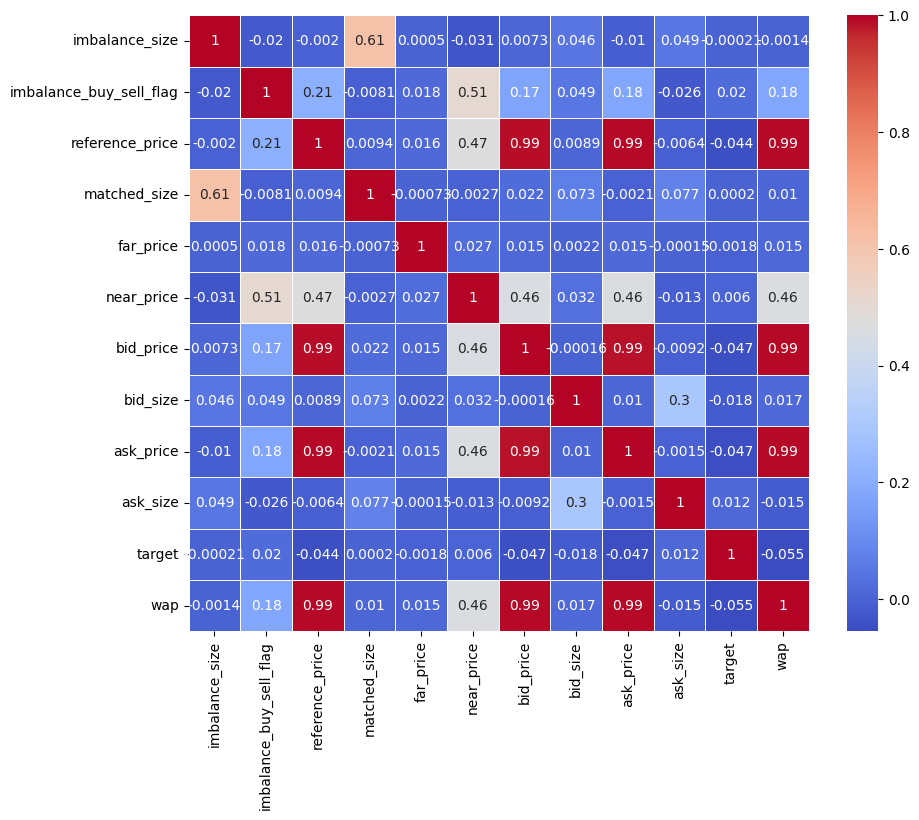

In [ ]:
columns_to_fill = ['imbalance_size', 'imbalance_buy_sell_flag', 'reference_price', 'matched_size', 'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price', 'ask_size', 'target', 'wap']
correlation_matrix = df[columns_to_fill].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()

Highly correlated - These show some v high correlation values (0.97-0.99)
* reference_price - bid_price - ask_price - wap

* Intuitevely I feel that, bid and ask price correlation is because a high ask price means more demand in market, which implies a high bid prices as well. So it is like a self-fulfilling loop, where rising bid prices lead to rising ask prices and vice versa.

* Reference price takes into account the bid and ask prices because it wants to find a price where lots of people are ready to trade. Reference price will also be somewhere inbetween these two prices, so it is limited inbetween both. So, when the bid and ask prices are rising, it means the reference price is also bound to rise.

* wap is just a weighted price function of bid and ask price, it also takes into account the bid and ask sizes as the 'weight', since it is a linear function of bid and ask price, it makes sense mathematically that it is highly correlated to them and to reference price. This explains why these 4 variables are correlated to each other.


Mildly correlated ~ 0.5
* imbalance_size & matched_size: I feel this does seem contradictory as high imbalance size would mean less matched size. But actually the volume of stocks traded is varying, if a high volume is traded, it means more imbalance and match size.

* imbalance_buy_sell_flag & near_price: A buy side imbalance (1) would lead to higher near_prices. Means recently more buyers than sellers of this stock, which does correlate to higher near_price. I am also not sure about correlation as the range of values is not the same (-1,0,1) and other is in decimals.

* near_price - reference_price - ask_price -  wap: A high near price means, recently the stocks bought in the non-auction market had a higher value. Which implies that there is more demand for these stocks hence the higher ask price.  

#### Q3: Average records stockID vs Day, 25 pts
distance function between entries
- a. autocorrelation, 10 pts
- b. measure the distance, 5 pts
- c. clustering algorithm, 10 pts



I am trying to define the consensus record as the average of two values reference_prize and wap. This is because:
1. reference_price --> This provides an indicator of the demand of stock based on the maximum amount of matched orders, it is an indicator of both buy and sell orders

2. wap --> This is a measure of the ACTUAL trade of stock, so basically how much data is traded in total, it considers that.


I chose the Spearman correlation because: Spearman correlation assesses the degree of a monotonic relationship between two variables, whether they consistently increase or decrease together. This method is non-parametric, meaning it doesn't rely on specific data distribution assumption (and in this case we donot know the distribution). Additionally, Spearman correlation is less influenced by outliers and can be effectively used with ordinal, interval, or ratio data

In [ ]:
from scipy.stats import spearmanr
df['consensus'] = (df['reference_price'] + df['wap'])/2
mean_df = df.groupby(['stock_id', 'date_id'], as_index=False)['consensus'].mean()


auto_corr_coeff_map = {}
stock_window_corr_coeff_map = {}
arr = []
stocks = df['stock_id'].unique()
for i in stocks:
  stock_values = mean_df[mean_df['stock_id'] == i]['consensus'].tolist()
  for window_size in range(1,20):
    sn = len(stock_values)
    if sn < window_size or sn - window_size < sn/2:
      continue
    spearman_corr, spearman_p_value = spearmanr(stock_values[0:sn-window_size], stock_values[window_size:sn])
    stock_window_corr_coeff_map[(i, window_size)] = spearman_corr

    arr.append(spearman_corr)
    try:
      auto_corr_coeff_map[spearman_corr].append((i, window_size))
    except:
      auto_corr_coeff_map[spearman_corr] = [(i, window_size)]

arr = [x for x in arr if not np.isnan(x)]
arr.sort()
print(arr[-10:-1])

values = arr[-10:-1]
for i in values:
  print(auto_corr_coeff_map[i])

[0.14322240453334656, 0.14362952964205575, 0.14561077092850921, 0.14566653935129925, 0.14632682938536493, 0.14720325975516085, 0.15487570300621026, 0.1627649208546912, 0.17911782786600242]
[(104, 9)]
[(134, 1)]
[(32, 3)]
[(159, 1)]
[(102, 15)]
[(94, 2)]
[(102, 16)]
[(187, 1)]
[(36, 5)]


The code looks at various stocks and different window sizes to understand how 'consensus' values relate to each other.
For each stock and window size pair, it calculates a correlation coefficient, which tells us how closely these 'consensus' values move together.
The code collects these correlation coefficients and in a sorted order.
This analysis is beneficial for gaining insights into how 'consensus' values for different stocks correlate and whether the correlation strength changes with varying window sizes.

I tried plotting average consensus values for some stocks over days, but the graphs are difficult to interpret. It would be better if we could just calculate the correlation between the consensus series of various stock ids.

In [ ]:
n = len(stocks)
cnt = 0
arr = []
corr_coeff_map = {}

for i in range(n):
  row_i = mean_df[mean_df['stock_id'] == i]['consensus']
  for j in range(i+1, n):
      row_j = mean_df[mean_df['stock_id'] == j]['consensus']
      if len(row_i) != len(row_j):
        continue
      correlation_coefficient, spearman_p_value = spearmanr(row_i, row_j)
      arr.append(correlation_coefficient)
      corr_coeff_map[correlation_coefficient] = (i, j)
arr = [x for x in arr if not np.isnan(x)]
arr.sort()

In [ ]:
print('Top 10 correlated stocks')

for i in range(1,11):
  print(f'Correlation between stocks {round(arr[-i],5)}, between stocks {corr_coeff_map[arr[-i]]}')

Top 10 correlated stocks
Correlation between stocks 0.95043, between stocks (84, 175)
Correlation between stocks 0.85114, between stocks (7, 141)
Correlation between stocks 0.80926, between stocks (17, 141)
Correlation between stocks 0.80905, between stocks (140, 183)
Correlation between stocks 0.80868, between stocks (72, 183)
Correlation between stocks 0.80023, between stocks (141, 183)
Correlation between stocks 0.78223, between stocks (126, 141)
Correlation between stocks 0.78068, between stocks (23, 183)
Correlation between stocks 0.77985, between stocks (23, 27)
Correlation between stocks 0.77807, between stocks (7, 17)


The group of stocks (84,175), (7,141) seem to be highly correlated according to the average consensus values. Let's try to plot them!

<Figure size 800x600 with 0 Axes>

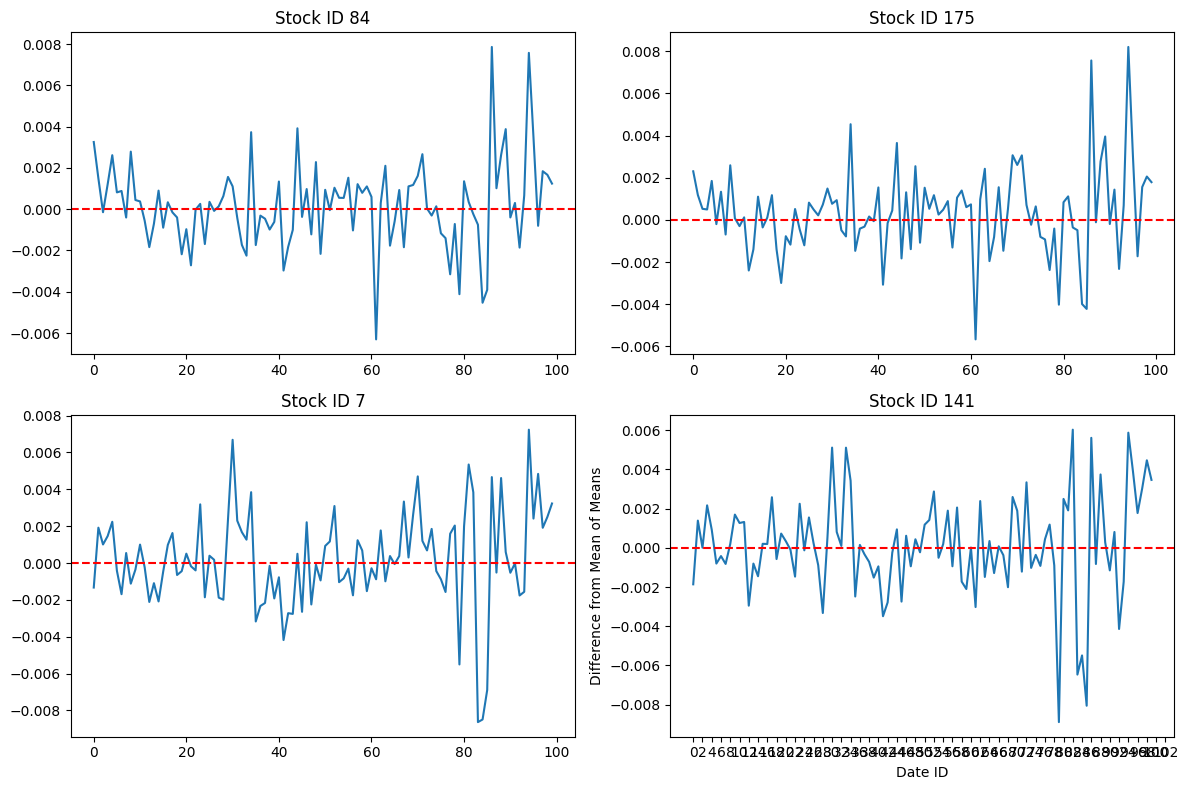

In [ ]:
plt.figure(figsize=(8, 6))

stock_ids = [84,175,7,141]
num_plots = len(stock_ids)
num_plots_per_row = 2
num_rows = (num_plots + num_plots_per_row - 1) // num_plots_per_row

fig, axes = plt.subplots(num_rows, num_plots_per_row, figsize=(12, 4*num_rows))

axes = axes.flatten()

for i, stock_id in enumerate(stock_ids):
    mean_of_means = mean_df[mean_df['stock_id'] == stock_id]['consensus'].mean()
    tmp_df = mean_df[mean_df['stock_id'] == stock_id].copy()
    tmp_df['consensus'] = tmp_df['consensus'] - mean_of_means
    plt.xticks(tmp_df['date_id'][::2])

    tmp_df = tmp_df.iloc[:100]
    axes[i].plot(tmp_df['date_id'], tmp_df['consensus'])
    axes[i].axhline(y=0, color='red', linestyle='--', label='Zero Line')
    axes[i].set_title(f'Stock ID {stock_id}')

for i in range(num_plots, num_rows * num_plots_per_row):
    fig.delaxes(axes[i])

plt.xlabel('Date ID')
plt.ylabel('Difference from Mean of Means')
plt.tight_layout()
plt.show()

The plots are highly similar, indicating that these two stocks probably belong to similar industries.

But what about the lag with itself? The series is highly correlated with itself at which lag?

In [ ]:
result = df.groupby(['stock_id', 'date_id'])[['wap', 'reference_price']].mean()
result.reset_index(inplace=True)
result['consensus'] = result[['reference_price', 'wap']].mean(axis=1)
autocorrelation_results = []
for stock_id in result['stock_id'].unique():
    stock_data = result[result['stock_id'] == stock_id]
    avg_distances = []
    for k in range(-10, 0):
        if k!=0:
          avg_distance = stock_data['consensus'].corr(stock_data['consensus'].shift(k))
          avg_distances.append(avg_distance)
    autocorr = pd.Series(avg_distances).max()
    max_index = avg_distances.index(autocorr)
    autocorrelation_results.append({'stock_id': stock_id, 'autocorrelation': autocorr, 'k':max_index})
autocorrelation_df = pd.DataFrame(autocorrelation_results)

The above code calculates the k at which the autocorrelation with itself is highest. This can give us insight into periodicity of stocks.

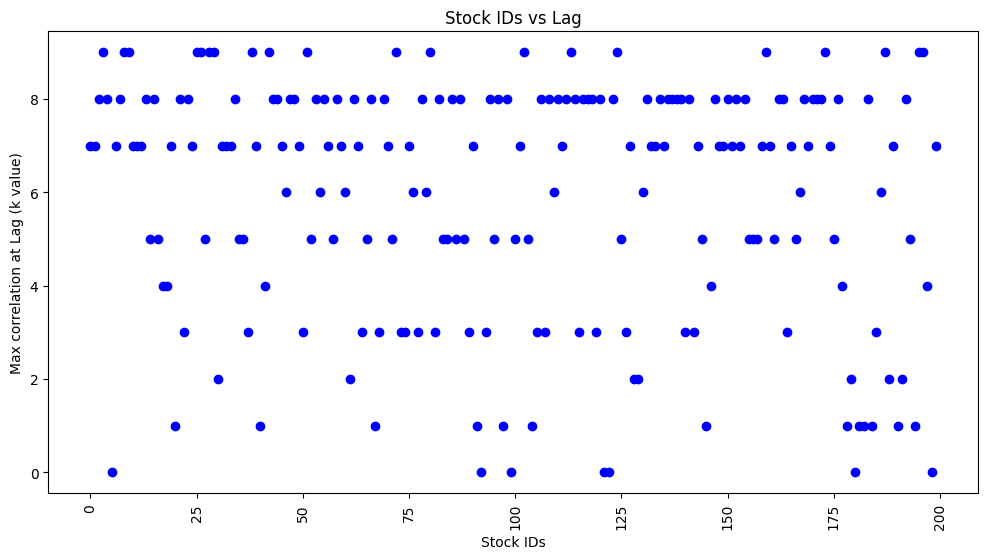

In [ ]:
stock_ids = autocorrelation_df['stock_id']
autocorrelations = autocorrelation_df['k']
plt.figure(figsize=(12, 6))
plt.scatter(stock_ids, autocorrelations, color='blue')
plt.title('Stock IDs vs Lag')
plt.xlabel('Stock IDs')
plt.ylabel('Max correlation at Lag (k value)')
plt.xticks(rotation=90)
plt.show()

This plot shows how the maximum autocorrelation is occuring at a lag of 8 days with itself. This is an interesting finding as it may reflect that stocks are correlated weekly and that weekly trends matter.

Now trying to cluster stocks using reference_price, wap, far_price, near_price...

In [ ]:
grouped = df.groupby('stock_id')
average_prices = grouped['reference_price'].mean()
average_prices = pd.concat([average_prices, grouped['wap'].mean()], axis = 1)
display(average_prices.head())

,reference_price,wap
stock_id,,
0,0.999739,0.999747
1,0.999907,0.999915
2,1.000166,1.000159
3,0.999942,0.999942
4,0.999801,0.999806


Trying the Elbow method to find appropriate number of clusters which I got from this reference

https://www.statology.org/elbow-method-in-python/

The elbow point on the plot of k against SSD( sum of squared distances) represents the optimal number of clusters. It's the point where the rate of decrease in SSD sharply changes, creating an "elbow" shape in the plot. The goal is to find the value of k where adding more clusters doesn't significantly reduce the SSD. So basically, the least number of clusters which give most information gain.

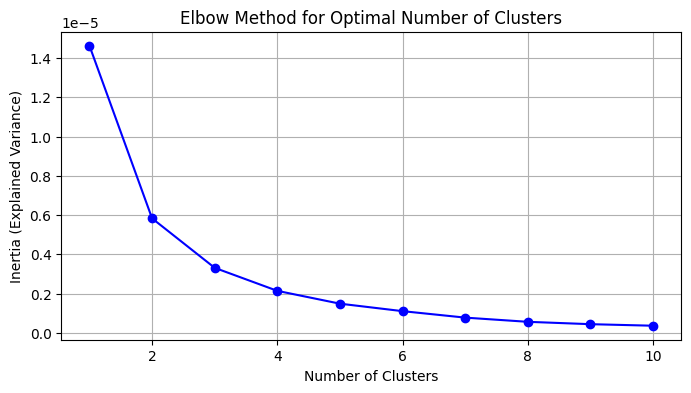

In [ ]:
from sklearn.cluster import KMeans

range_of_clusters = range(1, 11)
inertia_values = []

for k in range_of_clusters:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(average_prices)
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range_of_clusters, inertia_values, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Explained Variance)')
plt.grid()
plt.show()

Not much significant information gain after 3 clusters, so k = 3

In [ ]:
features = average_prices[['reference_price', 'wap']]
k = 3
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(features)
average_prices['cluster'] = kmeans.labels_

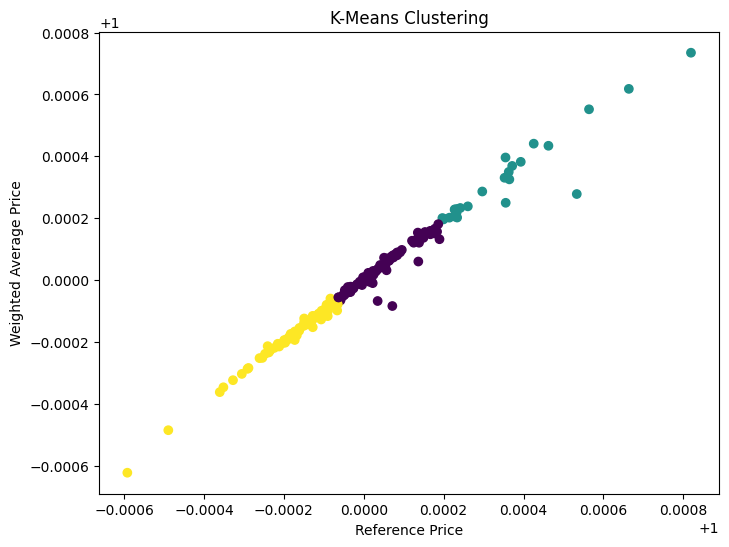

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(average_prices['reference_price'], average_prices['wap'], c=average_prices['cluster'], cmap='viridis')
plt.title('K-Means Clustering')
plt.xlabel('Reference Price')
plt.ylabel('Weighted Average Price')
plt.show()

The points do seem to be clustered fine, however the issue is that reference price and wap are highly correlated, which doesnt give us diverse feature points. Maybe we can try the clustering with two other values which are not much correlated to each other?

,reference_price,imbalance_size
stock_id,,
0,0.999739,2.189610e+06
1,0.999907,3.117756e+05
2,1.000166,9.910250e+05
3,0.999942,4.783389e+06
4,0.999801,1.936750e+06


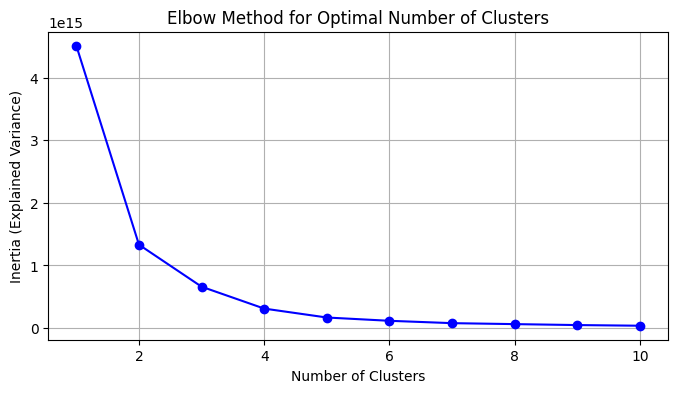

In [ ]:
grouped = df.groupby('stock_id')
average_prices = grouped['reference_price'].mean()
average_prices = pd.concat([average_prices, grouped['imbalance_size'].mean()], axis = 1)
display(average_prices.head())
range_of_clusters = range(1, 11)
inertia_values = []

# Apply k-means for each number of clusters and record the variance
for k in range_of_clusters:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(average_prices)
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range_of_clusters, inertia_values, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Explained Variance)')
plt.grid()
plt.show()

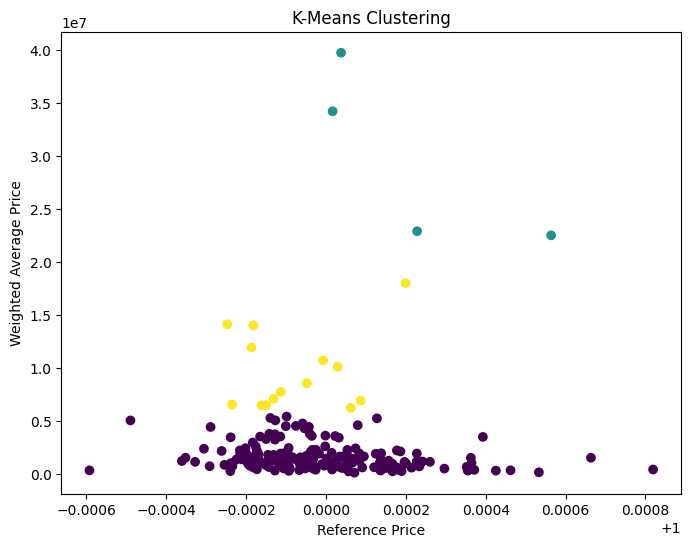

In [ ]:
features = average_prices[['reference_price', 'imbalance_size']]
k = 3
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(features)
average_prices['cluster'] = kmeans.labels_
plt.figure(figsize=(8, 6))
plt.scatter(average_prices['reference_price'], average_prices['imbalance_size'], c=average_prices['cluster'], cmap='viridis')
plt.title('K-Means Clustering')
plt.xlabel('Reference Price')
plt.ylabel('Weighted Average Price')
plt.show()

For both the variable combinations, the number of clusters is the same, and we can say that there are approximately 3 kind of stocks. I chose imbalance size and reference price as they had negligible correlation.

#### Q4: Closing trajectory of stocks on each day highly correlated, 25 pts
- a. Make three plots, 10 pts
- b. permutation test for statistical confidence, p-value, 15 pts


In [ ]:
display(result.head())

,stock_id,date_id,wap,reference_price,consensus
0,0,0,0.999356,0.999418,0.999387
1,0,1,0.999240,0.999287,0.999264
2,0,2,0.998651,0.998583,0.998617
3,0,3,0.998232,0.998197,0.998215
4,0,4,1.000009,0.999977,0.999993


I considered 20 days and 15 stocks to make the analysis clear and understandable.

In [ ]:
subset_result = result[(result['date_id']<30) & (result['stock_id']<15)]
print(subset_result.shape)

(450, 5)


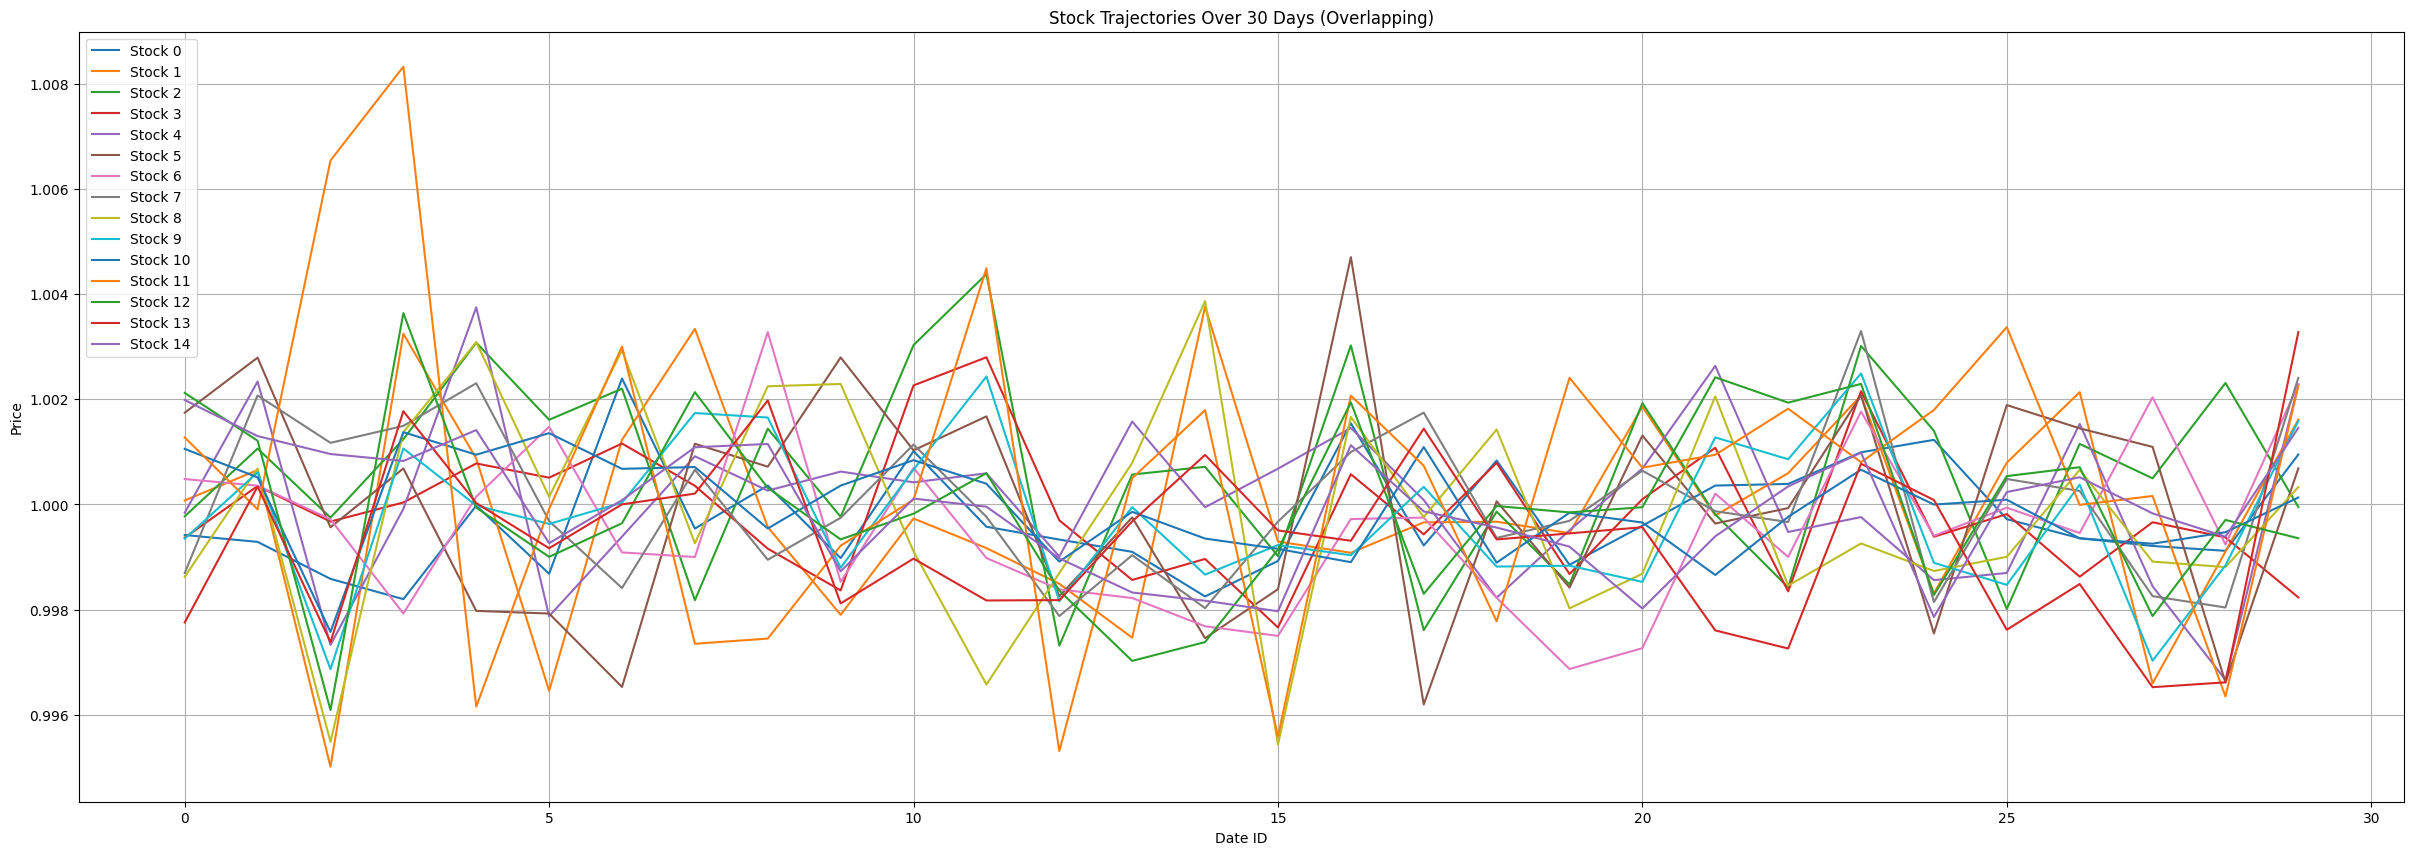

In [ ]:
plt.figure(figsize=(30, 10))

for stock_id in subset_result['stock_id'].unique():
    subset = subset_result[(subset_result['stock_id'] == stock_id) & (subset_result['date_id'] < 30)]
    plt.plot(subset['date_id'], subset['reference_price'], label=f'Stock {stock_id}')

plt.title('Stock Trajectories Over 30 Days (Overlapping)')
plt.xlabel('Date ID')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

Some key features of the above plot are that on some days, the reference price is plunging down and for some other stocks it is rising. For example, at around day_id 2 we have many stocks plunging down, but at the same time, one is quite high.

This can be a case like some outside situation where for e.g. COVID led to high medical stocks and other low stocks. This can be one example. Some stocks are moving in sync, while some are opposite and some have no apparent relationship. We need to explore this more.

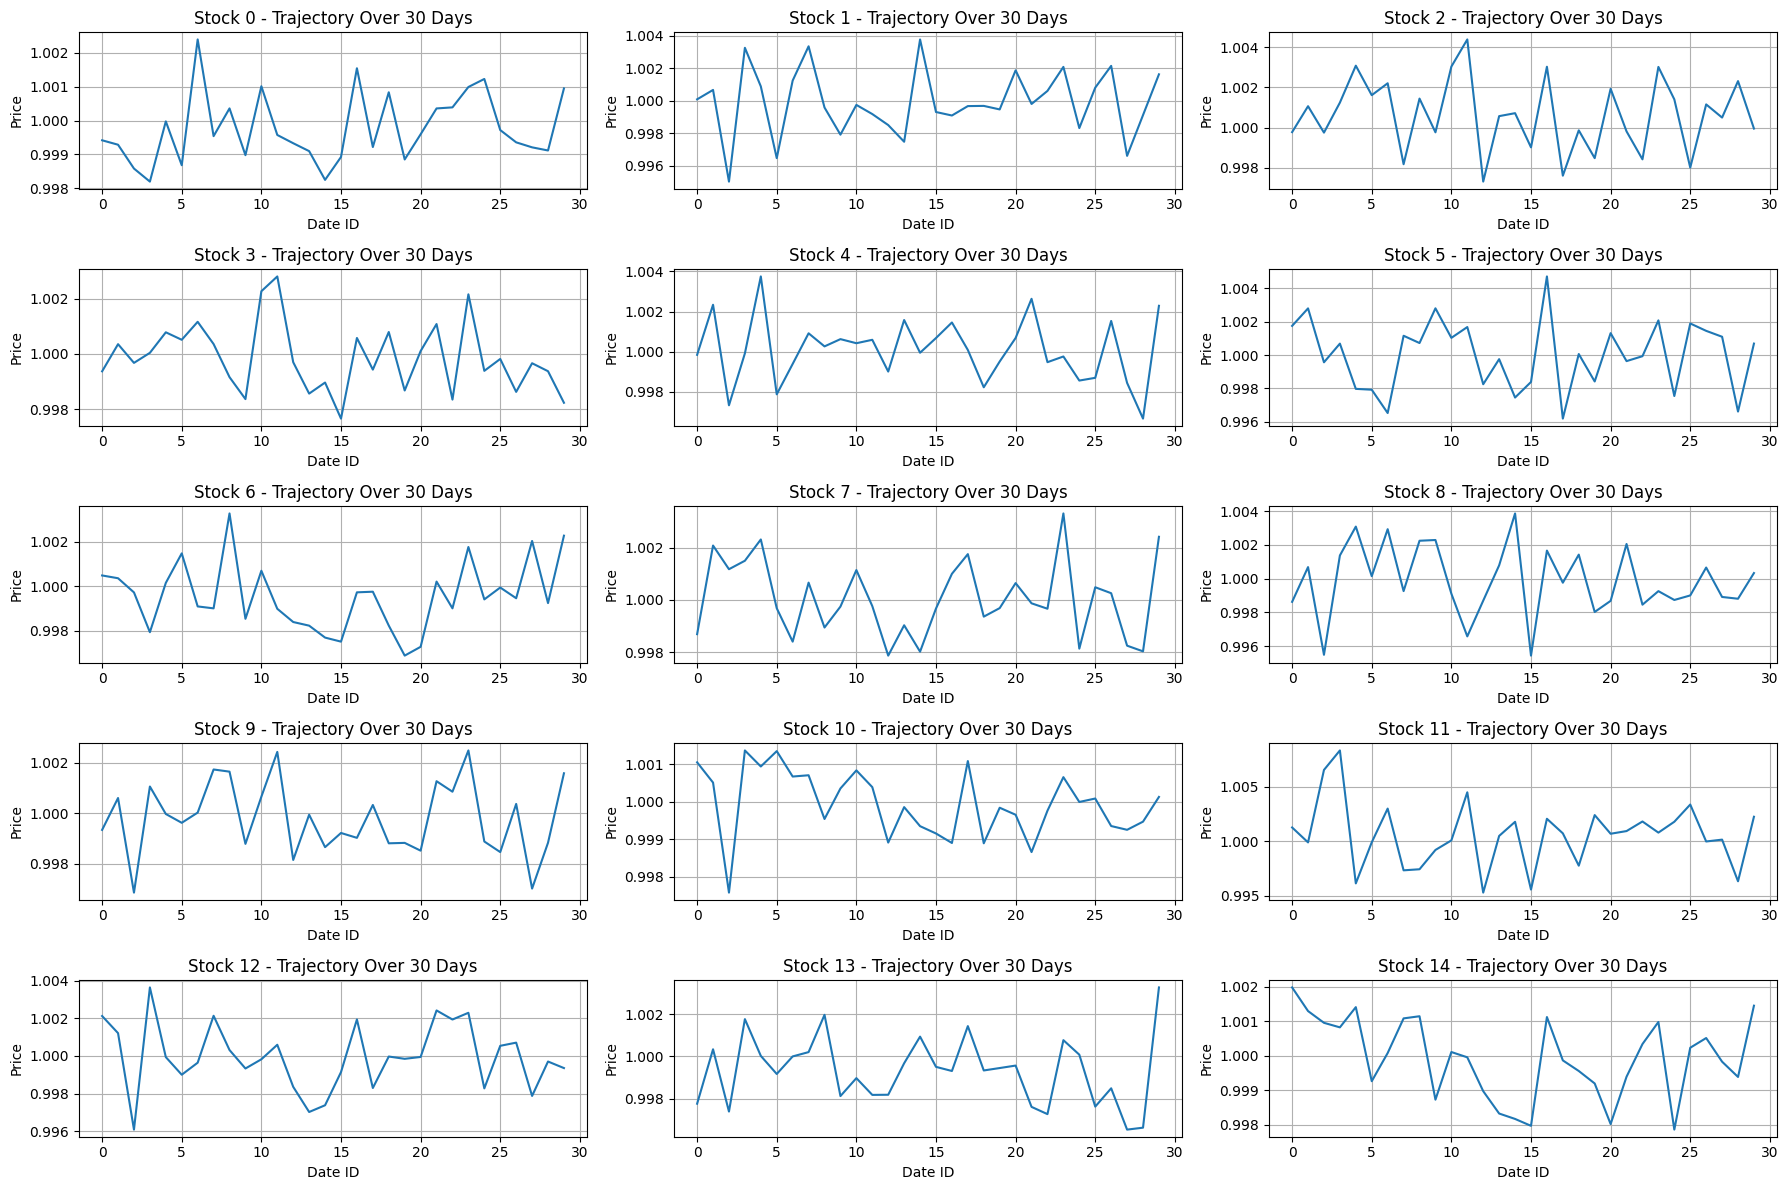

In [ ]:
unique_stock_ids = subset_result['stock_id'].unique()
num_plots = len(unique_stock_ids)
num_cols = 3
num_rows = (num_plots - 1) // num_cols + 1

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 12))

for i, stock_id in enumerate(unique_stock_ids):
    subset = subset_result[(subset_result['stock_id'] == stock_id) & (subset_result['date_id'] < 30)]
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]

    ax.plot(subset['date_id'], subset['reference_price'])
    ax.set_title(f'Stock {stock_id} - Trajectory Over 30 Days')
    ax.set_xlabel('Date ID')
    ax.set_ylabel('Price')
    ax.grid(True)

for i in range(num_plots, num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

I have made these plots to investigate the downward spike at date_id 2 , as we can see that a lot of stocks do have it but then go on to follow totally different trajectories.

Which means that day 2 was probably some external event which effected various stocks in a variety of industries.

For example, stock 10 and stock 13 fall at day 2 but stock 10 picks up and maintains a high price but stock 13 does not pick up as much. So their day 2 behaviour was influenced by some external factor, and later behaviour based on their own nature.

Stock id 2 and Stock id 3 have pretty similar graphs too, are they correlated?

In [ ]:
new_res = result.copy()
new_res = new_res.drop(columns=['wap','consensus'])
new_res = new_res[(new_res['stock_id']<15) & (new_res['date_id']<30)]
num_rows = 30
num_cols = 15
n1 = pd.DataFrame(index=range(num_rows), columns=range(num_cols))
n1 = n1.fillna(0)
for index, row in n1.iterrows():

    for column in range(num_cols):
        c1 = new_res['stock_id']==column
        c2 = new_res['date_id']==index
        n1.at[index, column] = new_res.loc[c1 & c2,'reference_price'].values[0]
display(n1.head())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.999418,1.000075,0.999773,0.999368,0.999842,1.001746,1.000483,0.998694,0.998622,0.999348,1.001057,1.001275,1.002123,0.997753,1.001987
1,0.999287,1.000654,1.001063,1.000350,1.002339,1.002794,1.000357,1.002075,1.000684,1.000610,1.000516,0.999907,1.001213,1.000341,1.001301
2,0.998583,0.995008,0.999749,0.999674,0.997325,0.999565,0.999718,1.001172,0.995481,0.996865,0.997573,1.006546,0.996086,0.997379,1.000959
3,0.998197,1.003249,1.001241,1.000037,0.999915,1.000685,0.997924,1.001495,1.001374,1.001065,1.001375,1.008331,1.003642,1.001774,1.000827
4,0.999977,1.000873,1.003079,1.000780,1.003752,0.997974,1.000148,1.002307,1.003088,0.999978,1.000946,0.996151,0.999939,1.000026,1.001415


A much more elegant way to study correlation between stocks rather than trying to see graph shapes, correlation matrix!

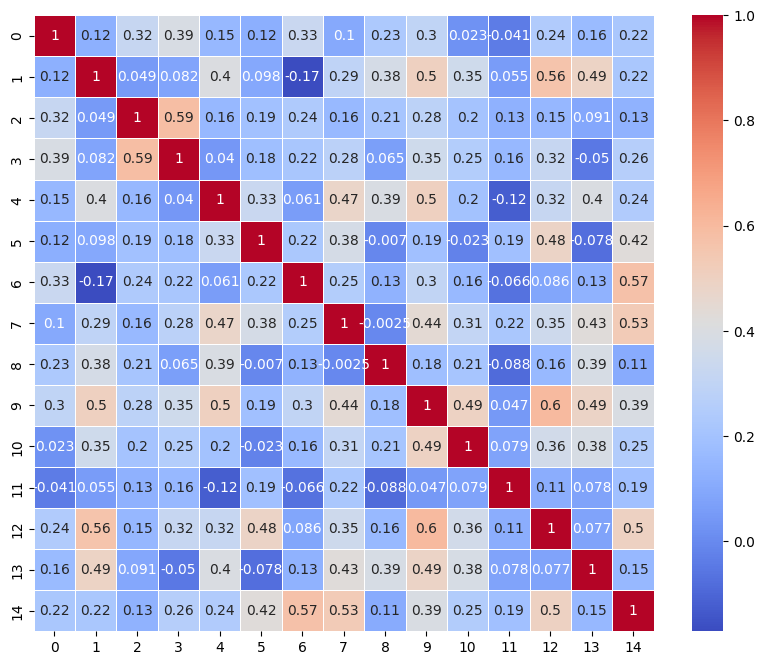

In [ ]:
correlation_matrix = n1.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()

Stocks 2 & 3 have a high correlation of 0.59, they had pretty similar plots above as well, which makes sense. Highly correlated trajectories will have similar shapes.

Is this correlation accidental or significant? Let us conduct a p-test to find out..

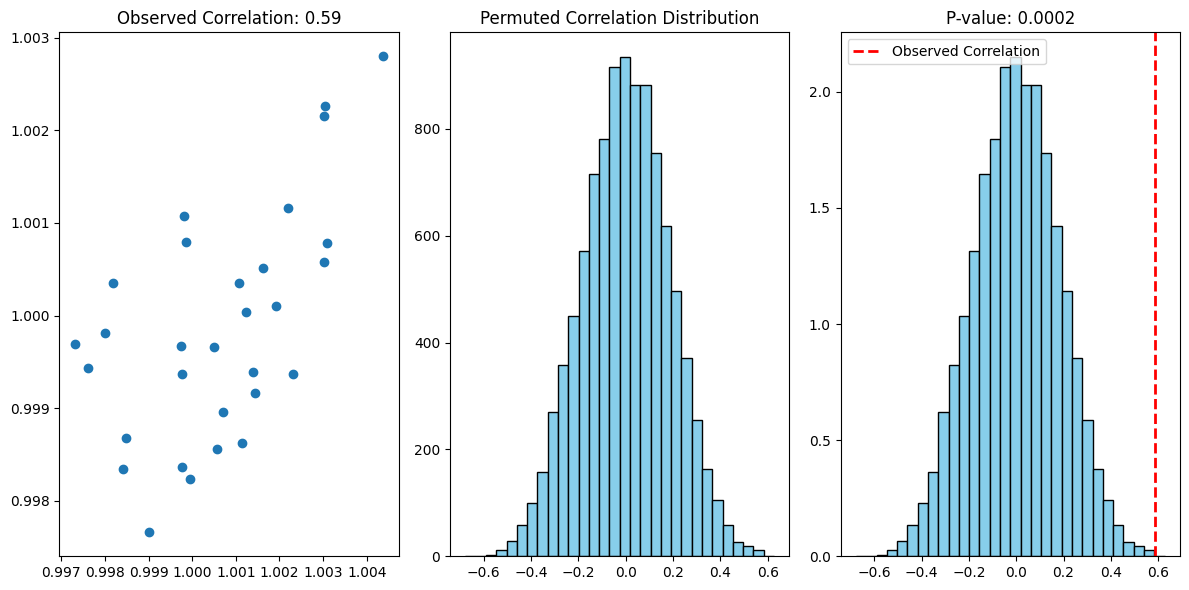

Observed Correlation: 0.586650940931144
P-Value: 0.00019998000199980003


In [ ]:
stock_a = 2
stock_b = 3
observed_corr = n1[stock_a].corr(n1[stock_b])

# Permutation test for correlation
num_permutations = 10000
permuted_correlations = []

for _ in range(num_permutations):
    shuffled_df = n1.copy()
    #shuffling rows of both stocks
    shuffled_df[stock_a] = np.random.permutation(shuffled_df[stock_a])
    shuffled_df[stock_b] = np.random.permutation(shuffled_df[stock_b])
    corr = shuffled_df[stock_a].corr(shuffled_df[stock_b])
    permuted_correlations.append(corr)

p_value = (np.sum(np.array(permuted_correlations) >= observed_corr) + 1) / (num_permutations + 1)

plt.figure(figsize=(12, 6))

# Plot 1: Scatter plot of observed correlation
plt.subplot(131)
plt.scatter(n1[stock_a],n1[stock_b])
plt.title(f'Observed Correlation: {observed_corr:.2f}')

# Plot 2: Histogram of permuted correlations
plt.subplot(132)
plt.hist(permuted_correlations, bins=30, color='skyblue', edgecolor='black')
plt.title('Permuted Correlation Distribution')

# Plot 3: P-value distribution
plt.subplot(133)
plt.hist(permuted_correlations, bins=30, color='skyblue', edgecolor='black', cumulative=False, density=True)
plt.axvline(observed_corr, color='red', linestyle='dashed', linewidth=2, label='Observed Correlation')
plt.title(f'P-value: {p_value:.4f}')
plt.legend()

plt.tight_layout()
plt.show()

print(f'Observed Correlation: {observed_corr}')
print(f'P-Value: {p_value}')

These plots support our hypothesis that after many random shufflings, it is very difficult to get a correlation of 0.69. The probability of getting such correlation is actually 0.00019% (p-value) which makes this result statistically significant and not occuring by chance.

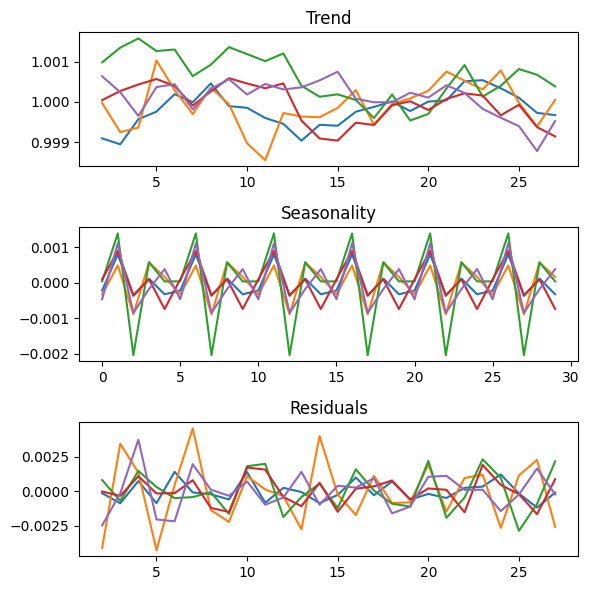

In [ ]:
import statsmodels.api as sm
# Create subplots for trend, seasonality, and residuals
fig, axs = plt.subplots(3, 1, figsize=(6, 6))

n2 = n1.copy()
columns_to_drop = [6, 7, 8, 9, 5, 10, 11, 12, 13, 14]
n2 = n2.drop(n2.columns[columns_to_drop], axis=1)

for column in n2.columns:
    stock_data = n2[column]
    decomposition = sm.tsa.seasonal_decompose(stock_data, model='additive', period=5)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Plot the trend for each stock
    axs[0].plot(trend, label=f'Stock {column}')

    # Plot the seasonality for each stock
    axs[1].plot(seasonal, label=f'Stock {column}')

    # Plot the residuals for each stock
    axs[2].plot(residual, label=f'Stock {column}')


axs[0].set_title('Trend')
axs[1].set_title('Seasonality')
axs[2].set_title('Residuals')

# axs[0].legend(loc='upper left')
# axs[1].legend(loc='upper left')
# axs[2].legend(loc='upper left')

plt.tight_layout()
plt.show()

Since our data is very clearly a time series, it is important to decompose into its components and study.

I decomposed by choosing a period as 5 because it signifies the next working day in the week for which data is recorded. We can see a clear seasonality of each stock.

The trend represents how the stock performs in a longer run.

The residuals are an indicator of outside events which influence the stock prices.

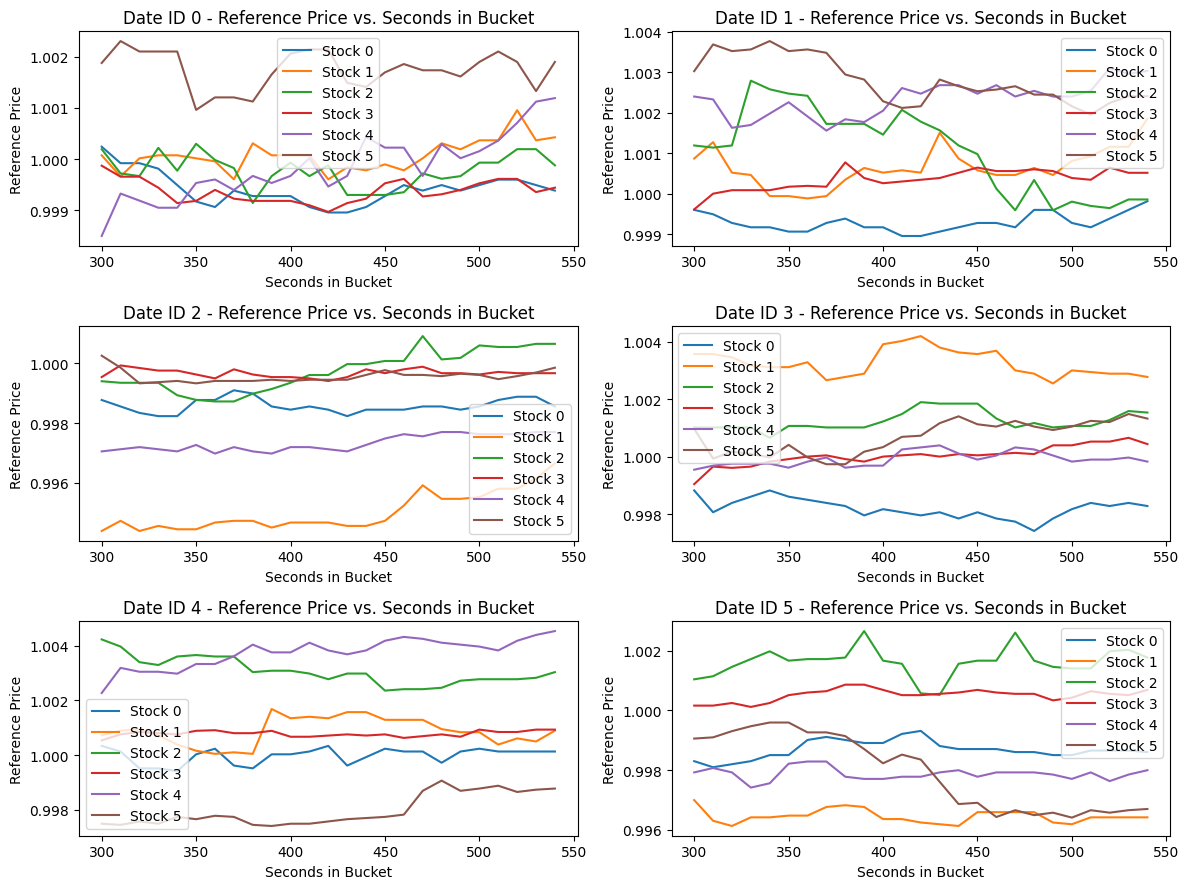

In [ ]:
num_rows = 3
num_cols = 2
selected_date_ids = [0, 1, 2, 3, 4,5]
selected_stock_ids = [0, 1, 2, 3, 4, 5]

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 9))

axs = axs.flatten()

for i, date_id in enumerate(selected_date_ids):
    ax = axs[i]

    ax.set_title(f'Date ID {date_id} - Reference Price vs. Seconds in Bucket')


    for stock_id in selected_stock_ids:
        stock_data = df[(df['stock_id'] == stock_id) & (df['date_id'] == date_id)]

        # Plotting the reference price vs. seconds in bucket for the current stock
        ax.plot(stock_data['seconds_in_bucket'], stock_data['reference_price'], label=f'Stock {stock_id}')

    ax.set_xlabel('Seconds in Bucket')
    ax.set_ylabel('Reference Price')
    ax.legend()

for i in range(len(selected_date_ids), num_rows * num_cols):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()


These plots signify the trading activity of different stocks in one particular day, after 300 seconds. In this plot, we can clearly see that there are some days where there are not much changes and the market seems 'quiet' such as date_id 2, while there are some days such that lot of fluctuating in prices in aster 300 seconds such as Day 0 for all stocks. This shows that there are some days with higher trading activity than others, which affects all stocks.

#### Q5: Best prediction model, any approaches, 25 pts


In [ ]:
result = pd.DataFrame({
        'unique': df.nunique() == len(df),
        'cardinality': df.nunique(),
        'with_null': df.isna().any(),
        'num_null': df.isna().sum(),
        'null_%': round((df.isna().sum() / len(df)) * 100, 2),
        '1st_row': df.iloc[0],
        'random_row': df.iloc[np.random.randint(low=0, high=len(df))],
        'last_row': df.iloc[-1],
        'dtype': df.dtypes
})

display(result)

,unique,cardinality,with_null,num_null,null_%,1st_row,random_row,last_row,dtype
stock_id,False,200,False,0,0.0,0,159,199,int64
date_id,False,481,False,0,0.0,0,146,480,int64
seconds_in_bucket,False,25,False,0,0.0,300,390,540,int64
imbalance_size,False,1219399,False,0,0.0,0.0,0.0,1884285.71,float64
imbalance_buy_sell_flag,False,3,False,0,0.0,0,0,-1,int64
reference_price,False,27686,False,0,0.0,1.000241,0.998117,1.002129,float64
matched_size,False,1327067,False,0,0.0,26670118.88,13068100.59,24073677.32,float64
far_price,False,123661,False,0,0.0,1.000241,0.998117,1.000859,float64
near_price,False,84625,False,0,0.0,1.000241,0.998117,1.001494,float64
bid_price,False,27307,False,0,0.0,1.000026,0.997984,1.002129,float64


In [ ]:
final_features_df = df.copy()
final_features_df = final_features_df.drop(['date_id', 'stock_id','time_id','row_id'], axis = 1)
final_features_df['imbalance_volume'] = final_features_df['imbalance_size']*final_features_df['imbalance_buy_sell_flag']
final_features_df = final_features_df.drop(['imbalance_buy_sell_flag', 'imbalance_size'], axis = 1)
display(final_features_df.head())

,seconds_in_bucket,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,consensus,imbalance_volume
5730,300,1.000241,26670118.88,1.000241,1.000241,1.000026,19319.31,1.000241,16149.55,1.000143,-10.039806,1.000192,0.00
5731,300,1.000073,3242054.27,0.981974,0.994490,0.999544,43205.40,1.000308,2042.76,1.000273,-1.329780,1.000173,-242332.96
5732,300,1.000193,4671376.00,1.000193,1.000193,0.999035,18971.00,1.001036,59688.26,0.999518,14.009476,0.999856,0.00
5733,300,0.999870,41057776.66,1.003870,1.002279,0.999827,25569.50,1.000042,37897.50,0.999914,-4.339814,0.999892,2914730.16
5734,300,0.998496,38356174.88,1.007894,1.007894,0.998357,14446.00,0.998703,2601.18,0.998650,10.850430,0.998573,3396923.02


In [ ]:
target = final_features_df['target']

feature_columns = ['seconds_in_bucket', 'reference_price', 'far_price', 'near_price', 'bid_price', 'ask_price','bid_size','ask_size', 'wap', 'imbalance_volume']

X = final_features_df[feature_columns]
y = final_features_df['target']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

model = LinearRegression()

mae_scores = -cross_val_score(model, X_scaled, y, cv=5, scoring='neg_mean_absolute_error')

mean_mae = mae_scores.mean()

print("Mean Absolute Error (MAE) Linear Regression:", mean_mae)

Mean Absolute Error (MAE) after feature scaling: 5.7028546149416055


Why Linear Regression?
1. It is easy to implement + fast on so much data. I had limited resources as my Colab seemed to be crashing on bigger models.
2. Under the assumption that the data is linearly correlated, which is an issue as stock data can be noisy.

In [ ]:
target = final_features_df['target']
feature_columns = ['seconds_in_bucket', 'reference_price', 'far_price', 'near_price', 'bid_price', 'ask_price', 'bid_size', 'ask_size', 'wap', 'imbalance_volume']
X = final_features_df[feature_columns]
y = final_features_df['target']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

model = DecisionTreeRegressor(max_depth=5)

mae_scores = -cross_val_score(model, X_scaled, y, cv=5, scoring='neg_mean_absolute_error')

mean_mae = mae_scores.mean()

print("Mean Absolute Error (MAE) with Decision Trees and feature scaling:", mean_mae)

Mean Absolute Error (MAE) with Decision Trees and feature scaling: 5.762528536094705


Why Decision Tree Regressor?
1. Unlike linear regression, it handles non-linear data better so I wanted to try this.
2. It can also handle noise and outliers better
3. Easy to compute

Feature Engineering + LGBM



I got the references for this from kaggle, I DO NOT claim to have written the source code from scratch. However, I have tried to explore why this is a popular choice on Kaggle for some of the well scoring models and what is the significance of this model and the feature engineering technique.

Feature Engineering:

https://alphascientist.com/feature_engineering.html

The author emphasizes on domain-specific feature engineering, We need to be avoiding redundancy and also ensuring that each feature has a value for every observation. There are some common transformations, including logs, differencing, rate of change, moving averages, z-scores which can help in feature engineering the stock market data which is often a time series related.

LGBM

https://neptune.ai/blog/lightgbm-parameters-guide

From what I understood is that:

* Efficiency: LightGBM can handle huge magnitude of data which can be high-dimensional.

* Gradient Boosting: With gradient boosting, it can handle both regression and classification tasks, making it versatile.

* Feature Engineering: LightGBM can handle a wide range of features both numerical and categorical.

* Hyperparameter: LightGBM offers extensive hyperparameters that can be tuned to optimize the model.


References:

https://www.kaggle.com/code/meli19/lgb-kf-baseline







1. **imbalance_ratio**: This tells how balanced or imbalanced the order book is. If it's near 1, things are balanced. If it's significantly higher or lower, there's imbalance, calculated amongst all stocks

2. **bid_ask_volume_diff**: I think it is the difference between what buyers want and what sellers offer. It shows if there are more buyers or sellers.

3. **mid_price**: Just the average between what buyers are willing to pay and what sellers are asking for.

4. **bid_plus_ask_sizes**: The total number of shares that people want to buy and sell right now.

5. **median_size**: It's like the typical trading volume for a stock. If actual volume is much higher or lower, it might indicate something interesting.

6. **std_size**: measures how volatile the trading volume for a stock is.

7. **high_volume**: A simple yes (1) or no (0) answer to whether trading volume is high compared to the typical volume.

8. **bid_ask_spread**: It's the gap between what buyers are willing to pay and what sellers are asking for.

9. **trading_volume**: Just the total trading volume at a specific time.


XGBOOST/CATBOOST

Again, I have not written this code. But I am just exploring why it is popular on Kaggle.

XGBoost --> known for its strong regularization techniques to prevent overfitting.

CatBoost --> useful when dealing with structured data that contains both numerical and categorical attributes, and handling missing data.

The features used are explained above

References:

https://www.kaggle.com/code/yuanzhezhou/baseline-lgb-xgb-and-catboost

#### Q6: submit model on Kaggle, 0 pts
Public Score: \ 5.3706
Private Score: \ 5.3706
Kaggle profile link: \ https://www.kaggle.com/priyankaborwanker
Screenshot(s): \ https://drive.google.com/file/d/13jv76133FhL7imMp1sbNc9VA-FgiMd_Y/view?usp=sharing
